In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_epidemic_model

In [3]:
from scipy.stats import norm

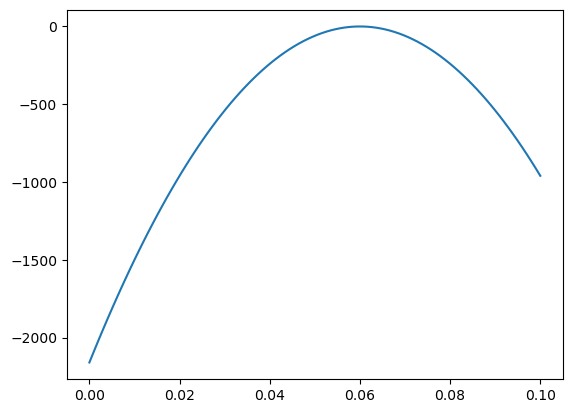

In [23]:
mu = 0.06
stdev = 0.005
l = 30

x_list = np.linspace(0,0.10,100)
res=[]
L2=[]
for x in x_list:
    res.append(l*(norm.logpdf(x, loc = mu, scale = stdev)-norm.logpdf(mu, loc = mu, scale = stdev)))
    L2.append(-l*(x-mu)**2/mu)
              
fig,ax=plt.subplots()
ax.plot(x_list, res)
#ax.plot(x_list, L2)           
plt.show()
plt.close()

In [3]:
def max_utility_function(I_star, alpha, beta, gamma, delta, psi, m, RL, l0):
    max_work_actual = (((1-alpha)*m*l0*(1-RL)*(1-psi))/(alpha*beta*I_star**beta+0.3))**(1/(beta-1))
    max_work_effective = (((1-alpha)*m*l0*(1-RL)*psi)/(alpha*beta*I_star**delta+0.3))**(1/(delta-1))
    l_i = l0*(RL + (1-RL)*((1-psi)*max_work_actual + psi*max_work_effective))
    max_leisure =(((1-alpha)*m*l_i*0.2)/(alpha*gamma*I_star**gamma+0.3))**(1/(gamma-1))
    return min(max_work_actual,1), min(max_work_effective,1), min(max_leisure, 1)

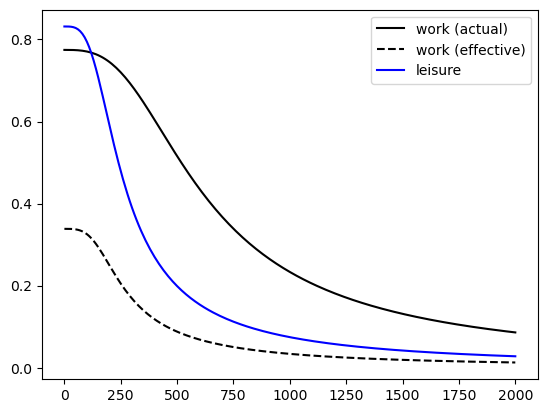

In [4]:
I_star = np.linspace(1,2000,201)

RL = 0.80
alpha = 1e-9
beta = 3
gamma = 3.5
delta = 3.5
psi = 0.1
l0 = 1
m = 1

work_actual = []
work_effective = []
leisure = []
for I in I_star:
    w_act, w_eff, l = max_utility_function(I, alpha, beta, gamma, delta, psi, m, RL, l0)
    work_actual.append(w_act)
    work_effective.append(w_eff)
    leisure.append(l)

fig,ax=plt.subplots()
ax.plot(I_star, work_actual, color='black', label='work (actual)')
ax.plot(I_star, work_effective, color='black', linestyle='--', label='work (effective)')
ax.plot(I_star, leisure, color='blue', label='leisure')
#ax.plot(I_star, leisure_actual, color='blue', linestyle='--', label='leisure')
ax.legend()
plt.show()
plt.close()

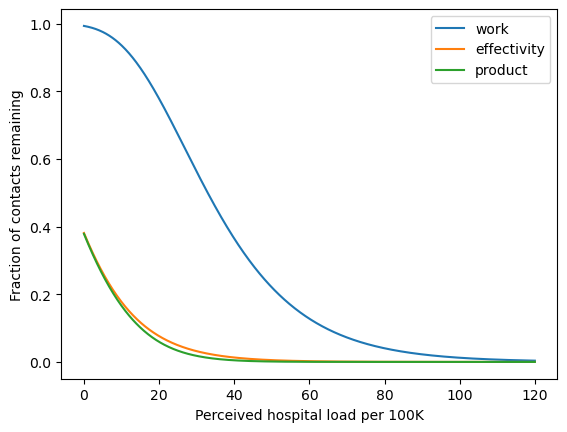

In [59]:
# parameters
ypsilon_work = 5
phi_work = 0.06

ypsilon_eff = 0.48
phi_eff = 0.09
# model
x = np.linspace(0,120,1000)
y_work = (1-np.exp(-ypsilon_work*np.exp(-phi_work*x)))
y_eff = 1-np.exp(-ypsilon_eff*np.exp(-phi_eff*x))

# visualize
fig,ax=plt.subplots()
ax.plot(x, y_work, label='work')
ax.plot(x, y_eff, label='effectivity')
ax.plot(x, y_work*y_eff, label='product')
ax.set_xlabel('Perceived hospital load per 100K')
ax.set_ylabel('Fraction of contacts remaining')
ax.legend()
plt.show()
plt.close()

In [18]:
country = 'SWE'
spatial = False
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')
simulation_start = '2020-03-01'
model = initialize_epidemic_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

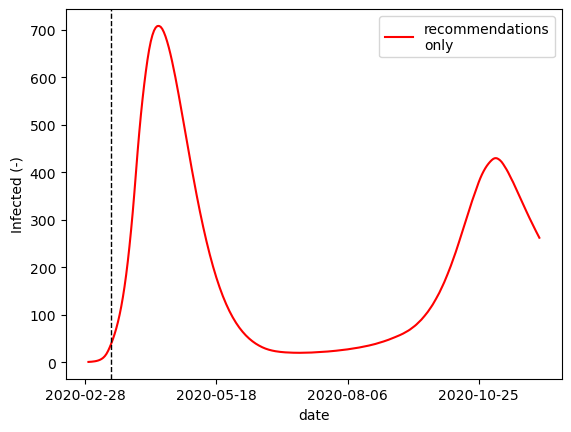

In [16]:
fig,ax = plt.subplots()

model.parameters['zeta'] = 100

# parameter estimates
pars = ['tau', 'ypsilon_eff', 'phi_eff', 'ypsilon_work', 'phi_work', 'ypsilon_leisure', 'phi_leisure', 'amplitude']
thetas = [1.29622186e+01, 6.21760218e-01, 4.96343021e-02, 1.67679210e+01, 1.00939834e-02, 1.47134829e+01, 1.57029663e-01, 3.77772349e-01]

# assign parameter estimates
for par, theta in zip(pars, thetas):
    model.parameters[par] = theta
    
# # economic lockdown, schools closed, preventive measures, social restrictions
# policies_df = pd.read_csv(f'../data/interim/eco/policies/policies_{country}.csv', index_col=[0], header=[0])
# model.parameters['economy_BE_lockdown_1'].loc[slice(None)] = policies_df['lockdown_1']
# model.parameters['economy_BE_phaseI'].loc[slice(None)] = policies_df['lockdown_release_phaseI']
# model.parameters['economy_BE_lockdown_Antwerp'].loc[slice(None)] = policies_df['lockdown_Antwerp']
# model.parameters['economy_BE_lockdown_2'].loc[slice(None)] = policies_df['lockdown_2']
# out = model.sim([simulation_start, '2020-12-01'])
# ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# # economic lockdown, schools open, preventive measures, social restrictions
# model.parameters['economy_BE_lockdown_1'].loc['P85'] = 0
# out = model.sim([simulation_start, '2020-12-01'])
# ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown (schools open)')

# #do-nothing
# model.parameters['economy_BE_lockdown_1'].loc[slice(None)] = 0
# model.parameters['economy_BE_phaseI'].loc[slice(None)] = 0
# model.parameters['economy_BE_lockdown_Antwerp'].loc[slice(None)] = 0
# model.parameters['economy_BE_lockdown_2'].loc[slice(None)] = 0
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='recommendations\nonly')

ax.legend()
ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

#plt.savefig(f'scenarios_{country}.png', dpi=600)
plt.show()
plt.close()

In [17]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(3, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

0.02981595609320694

In [19]:
# function to compute beta based on basic reproduction number
def compute_beta(R0, gamma, delta, s, a, G, N_home, N_work, N_other, demography):
    beta_i = R0/(s*(gamma + delta)*np.expand_dims(np.sum(N_home, axis=0),axis=1) + \
                 s*(gamma + a*delta)*np.expand_dims(np.sum(N_other, axis=0),axis=1) + \
                 s*(gamma + a*delta)*np.expand_dims(np.sum(G*N_work, axis=0),axis=1)
                )
    return sum(np.squeeze(beta_i)*demography/sum(demography))

# data
N_home = np.squeeze(model.parameters['N']['home'])
N_other = np.squeeze(model.parameters['N']['other'])
N_work = np.squeeze(model.parameters['N']['work'])
G = np.squeeze(model.parameters['G'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()

# compute beta if R0 = 3
compute_beta(3, model.parameters['gamma'], model.parameters['delta'], model.parameters['s'], model.parameters['a'],
                 G, N_home, N_work, N_other, demography.values)

0.03057038131919472